In [ ]:
!pip install catboost shap lime seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns

In [ ]:
import kagglehub

path_to_dataset = kagglehub.dataset_download("emrekaany/google-daily-stock-prices-2004-today")

print("Path to dataset files:", path_to_dataset)

Path to dataset files: /kaggle/input/google-daily-stock-prices-2004-today


In [ ]:
import os

folder_path = path_to_dataset
files = os.listdir(folder_path)
print(files)


['googl_daily_prices.csv']


## Датасет

Датасет

Название: Google Daily Stock Prices (2004–2025)
Источник: Kaggle
Целевая переменная: Цена закрытия акции (4. close)
Признаки:

1. open — цена открытия

2. high — максимальная цена дня

3. low — минимальная цена дня

5. volume — объем торгов

Созданные лаговые признаки:

1. Previous Day Close — цена закрытия предыдущего дня (close.shift(1))

2. 7-Day Moving Average — скользящее среднее за 7 дней

3. 15-Day Moving Average — скользящее среднее за 15 дней

In [ ]:
googl_data = pd.read_csv(path_to_dataset+"/googl_daily_prices.csv")
googl_data

,date,1. open,2. high,3. low,4. close,5. volume
0,2025-05-30,171.350,172.2050,167.4400,171.740,52639911.0
1,2025-05-29,174.000,174.4193,170.6300,171.860,29373803.0
2,2025-05-28,173.160,175.2650,171.9107,172.360,34783997.0
3,2025-05-27,170.160,173.1700,170.0000,172.900,37995670.0
4,2025-05-23,169.055,169.9600,167.8900,168.470,35211439.0
...,...,...,...,...,...,...
5224,2004-08-25,104.760,108.0000,103.8800,106.000,9188600.0
5225,2004-08-24,111.240,111.6000,103.5700,104.870,15247300.0
5226,2004-08-23,110.760,113.4800,109.0500,109.400,18256100.0
5227,2004-08-20,101.010,109.0800,100.5000,108.310,22834300.0


In [ ]:
# ! ВАЖНО столбец «дата» имеет формат даты и времени, и все отсортерованно в хронологическом порядке.
googl_data['date'] = pd.to_datetime(googl_data['date'])
googl_data = googl_data.sort_values(by='date').reset_index(drop=True)

# lag
googl_data['Previous Day Close'] = googl_data['4. close'].shift(1)
googl_data['7-Day Moving Average'] = googl_data['4. close'].rolling(window=7).mean()
googl_data['15-Day Moving Average'] = googl_data['4. close'].rolling(window=15).mean()

# 2025-05-30	171.350	172.2050	167.4400	171.740	52639911.0	записал что б не потерять

googl_data

,date,1. open,2. high,3. low,4. close,5. volume,Previous Day Close,7-Day Moving Average,15-Day Moving Average
0,2004-08-19,100.010,104.0600,95.9600,100.335,44659000.0,NaN,NaN,NaN
1,2004-08-20,101.010,109.0800,100.5000,108.310,22834300.0,100.335,NaN,NaN
2,2004-08-23,110.760,113.4800,109.0500,109.400,18256100.0,108.310,NaN,NaN
3,2004-08-24,111.240,111.6000,103.5700,104.870,15247300.0,109.400,NaN,NaN
4,2004-08-25,104.760,108.0000,103.8800,106.000,9188600.0,104.870,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5224,2025-05-23,169.055,169.9600,167.8900,168.470,35211439.0,170.870,166.938571,162.518667
5225,2025-05-27,170.160,173.1700,170.0000,172.900,37995670.0,168.470,168.215714,163.098000
5226,2025-05-28,173.160,175.2650,171.9107,172.360,34783997.0,172.900,169.097143,163.706667
5227,2025-05-29,174.000,174.4193,170.6300,171.860,29373803.0,172.360,169.857143,165.072000


In [ ]:
googl_data = googl_data.dropna()

features = ['1. open', '2. high', '3. low', '5. volume', 'Previous Day Close', '7-Day Moving Average', '15-Day Moving Average']
target = '4. close'

features_to_normalize = ['1. open', '2. high', '3. low', '4. close', '5. volume', 'Previous Day Close', '7-Day Moving Average', '15-Day Moving Average']


scaler = MinMaxScaler()

googl_data[features_to_normalize] = scaler.fit_transform(googl_data[features_to_normalize])

train_size = int(len(googl_data) * 0.8)
train_data = googl_data.iloc[:train_size]
test_data = googl_data.iloc[train_size:]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

X_train, y_train, X_test, y_test

<ipython-input-51-570eee2a90e0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  googl_data[features_to_normalize] = scaler.fit_transform(googl_data[features_to_normalize])


(       1. open   2. high    3. low  5. volume  Previous Day Close  \
 14    0.005817  0.005499  0.006101   0.028253            0.006477   
 15    0.005467  0.006806  0.006205   0.064684            0.006481   
 16    0.007222  0.007434  0.007987   0.057969            0.007517   
 17    0.007498  0.008654  0.008101   0.081420            0.008262   
 18    0.008559  0.009411  0.009279   0.080509            0.009632   
 ...        ...       ...       ...        ...                 ...   
 4181  0.669336  0.671153  0.674630   0.007073            0.673577   
 4182  0.669819  0.679165  0.678378   0.013064            0.673811   
 4183  0.682695  0.695973  0.693727   0.012008            0.679320   
 4184  0.701371  0.727639  0.712304   0.015398            0.702407   
 4185  0.723064  0.727303  0.731853   0.010185            0.733018   
 
       7-Day Moving Average  15-Day Moving Average  
 14                0.004872               0.005439  
 15                0.005019               0.005555  

In [ ]:
googl_data['Previous Day Close'] = googl_data['4. close'].shift(1)
googl_data['7-Day Moving Average'] = googl_data['4. close'].rolling(window=7).mean()
googl_data['15-Day Moving Average'] = googl_data['4. close'].rolling(window=15).mean()

<ipython-input-52-d3820763bf4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  googl_data['Previous Day Close'] = googl_data['4. close'].shift(1)
<ipython-input-52-d3820763bf4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  googl_data['7-Day Moving Average'] = googl_data['4. close'].rolling(window=7).mean()
<ipython-input-52-d3820763bf4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

## Модель

Модель прогнозирует нормализованную цену закрытия акций Google

In [ ]:
from catboost import CatBoostRegressor

# Инициализация CatBoost
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    verbose=100,  # Показывать логи каждые 100 итераций
    random_seed=42,
    loss_function='RMSE'
)

# Обучение модели
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

0:	learn: 0.1209019	test: 0.3870158	best: 0.3870158 (0)	total: 5.09ms	remaining: 5.08s
100:	learn: 0.0047836	test: 0.1114948	best: 0.1114948 (100)	total: 503ms	remaining: 4.48s
200:	learn: 0.0038732	test: 0.1038227	best: 0.1038183 (195)	total: 1.11s	remaining: 4.43s
300:	learn: 0.0033397	test: 0.1032226	best: 0.1032198 (293)	total: 1.85s	remaining: 4.31s
400:	learn: 0.0030008	test: 0.1028935	best: 0.1028935 (400)	total: 2.68s	remaining: 4.01s
500:	learn: 0.0027578	test: 0.1027181	best: 0.1027181 (500)	total: 3.66s	remaining: 3.65s
600:	learn: 0.0025543	test: 0.1025155	best: 0.1025151 (599)	total: 4.94s	remaining: 3.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1024898924
bestIteration = 631

Shrink model to first 632 iterations.


In [ ]:
# Предсказание
y_pred = model.predict(X_test)

print(y_pred)
# Метрики
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

[0.69239961 0.69202639 0.69221347 ... 0.03134076 0.03024575 0.0311458 ]
MAE: 0.05342284530094192
RMSE: 0.10248989222993767
R²: 0.9318951812799304


##  Глобальная интерпретация

### Важность признаков

Text(0.5, 1.0, 'CatBoost Feature Importance')

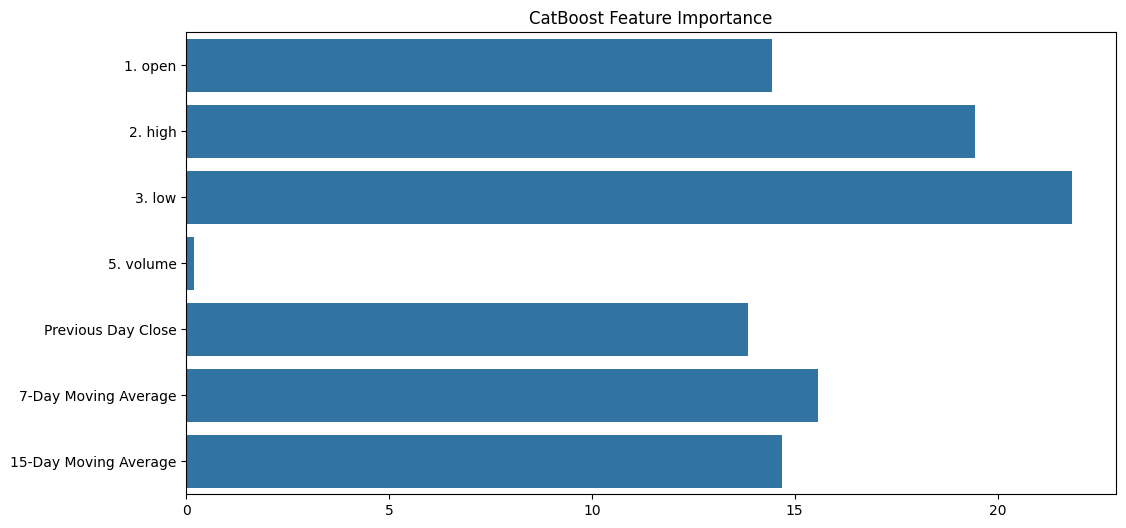

In [ ]:
feature_importances = model.get_feature_importance()
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('CatBoost Feature Importance')

### SHAP-анализ

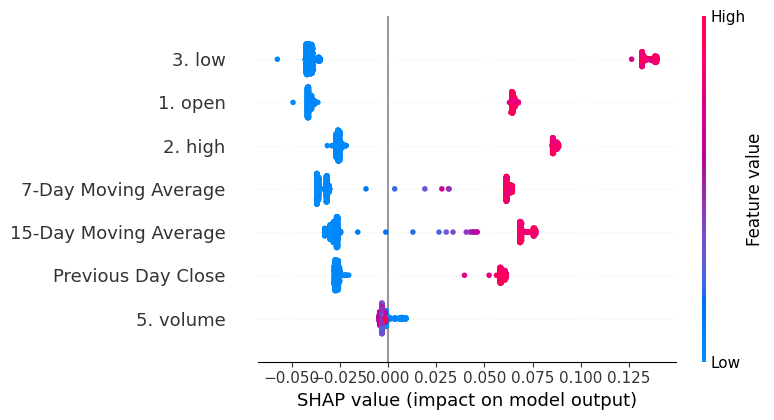

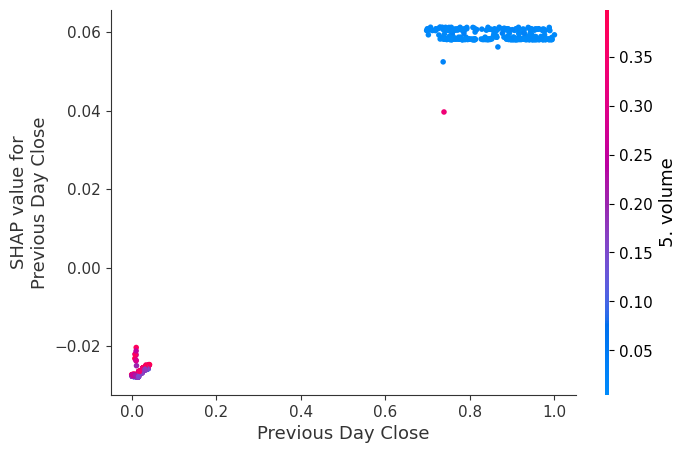

In [ ]:
import shap

# Инициализация explainer
explainer = shap.TreeExplainer(model)

# Вычисление SHAP значений
shap_values = explainer.shap_values(X_test)

# 1. Summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)

print()
# 2. Dependence plot для ключевых признаков
shap.dependence_plot("Previous Day Close", shap_values, X_test)

## Локальная интерпретация

### SHAP для конкретных наблюдений

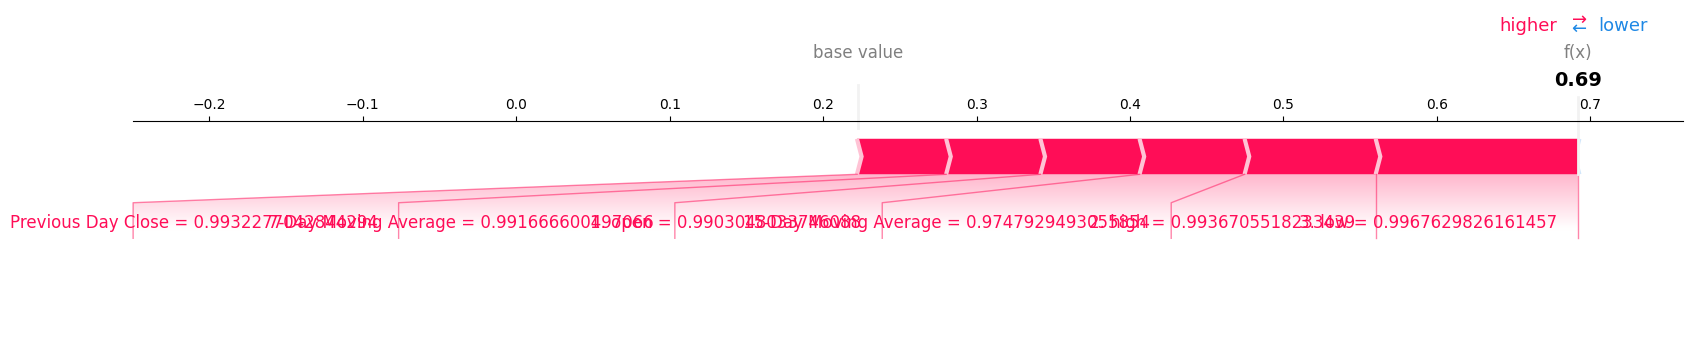

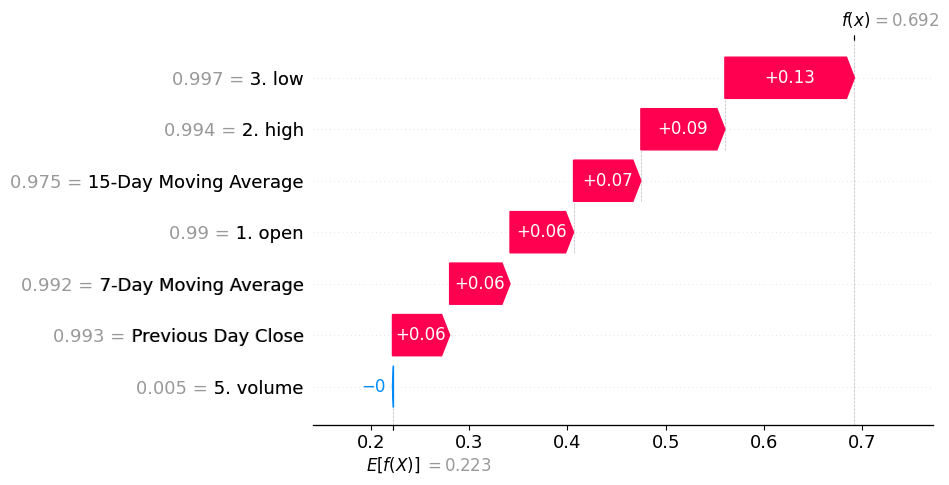

In [ ]:
max_error_idx = np.argmax(np.abs(y_test - y_pred))
shap.force_plot(  # мб убрать график дикий
    explainer.expected_value,
    shap_values[max_error_idx],
    X_test.iloc[max_error_idx],
    matplotlib=True
)

# Waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_values[max_error_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[max_error_idx],
    feature_names=features
))

### LIME-анализ

In [ ]:
from lime import lime_tabular

explainer_lime = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=features,
    mode='regression',
    verbose=True
)

# Объяснение для интересной точки
exp = explainer_lime.explain_instance(
    X_test.iloc[0],
    model.predict,
    num_features=10
)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Intercept 0.16376636415066548
Prediction_local [0.34282093]
Right: 0.6923996071846465


In [ ]:
shap.initjs()

# Пример новых данных (30 мая 2025)(Сейчас уже 01.06 но данные за сегодня будут позже, так что пока так)
new_data_point = pd.DataFrame([[
    171.35,   # open
    172.20,   # high
    167.44,   # low
    52639911, # volume
    170.00,   # previous close
    169.50,   # 7-day MA
    168.80    # 15-day MA
]], columns=features)

# Предсказание и объяснение
prediction = model.predict(new_data_point)
print(f"Predicted close: {prediction[0]}")

# SHAP объяснение
new_shap = explainer.shap_values(new_data_point)
shap.force_plot(explainer.expected_value, new_shap[0], new_data_point.iloc[0])

Predicted close: 0.6951394676055936


## Визулизация временных рядов

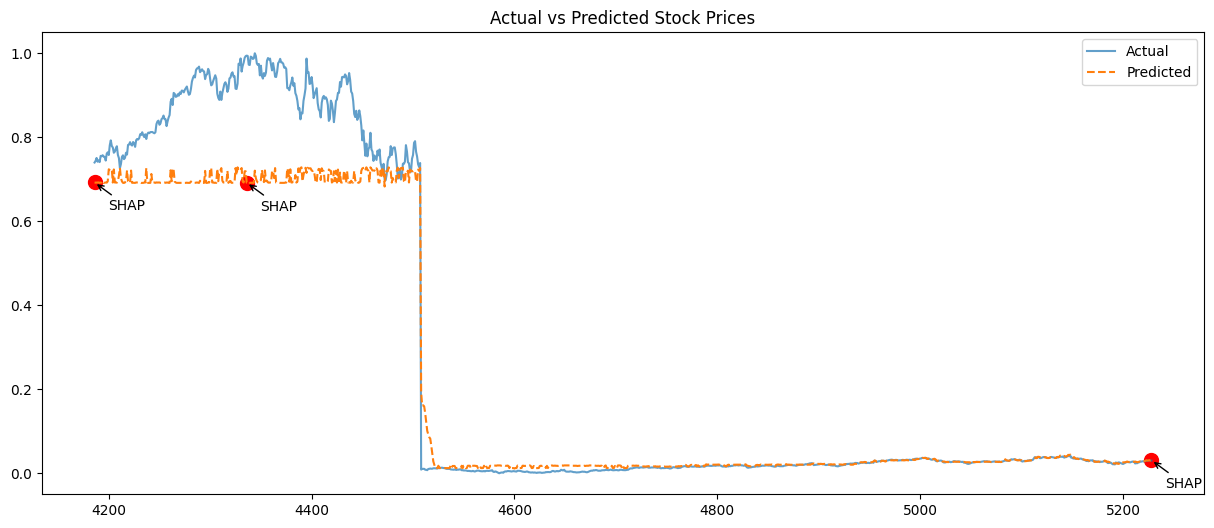

In [ ]:
# График фактических vs предсказанных значений
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, y_test, label='Actual', alpha=0.7)
plt.plot(test_data.index, y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()

# Добавление точек с SHAP объяснениями
interesting_points = [max_error_idx, 0, -1]  # Интересные индексы
for idx in interesting_points:
    plt.scatter(test_data.index[idx], y_pred[idx], color='red', s=100)
    plt.annotate(f"SHAP",
                 (test_data.index[idx], y_pred[idx]),
                 xytext=(10, -20),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->"))

Вывод

В ходе работы была успешно решена задача прогнозирования ежедневных цен закрытия акций Google с использованием CatBoostRegressor и методов интерпретации модели (SHAP и LIME).